Given a table of observations of anonymized health characteristics as columns, the goal is to predict whether an observation leads to a positive diagnosis.

# Dependencies

In [1]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not is_kaggle:
    !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    !pip install -q pandas numpy matplotlib seaborn fastai
    !pip install -q kaggle

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# prettier plots
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Prep

In [3]:
competition_name = "icr-identify-age-related-conditions"

if is_kaggle:
    input_path = Path(f"/kaggle/input/{competition_name}")
else:
    input_path = Path.home() / ".kaggle" / "input" / competition_name
    !kaggle competitions download -p {input_path.parent} {competition_name}
    !unzip -o {input_path}.zip -d {input_path}

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /home/krm/.kaggle/input/icr-identify-age-related-conditions.zip
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv  
  inflating: /home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv  


In [4]:
list(input_path.iterdir())

[PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),
 PosixPath('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [5]:
train_df = pd.read_csv(input_path / "train.csv")
train_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We have a columns `Id`, unique identifier for the observation, followed by 56 anonymized health characteristics and the predictions `Class`, where 1 is positive and 0 is negative.

In [7]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


The mean value of Class much closer to zero, which means that we have an more -ve observations than positive

<Axes: ylabel='count'>

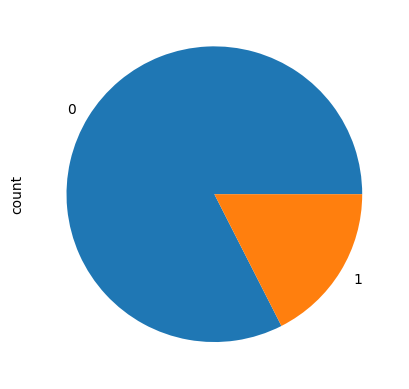

In [8]:
train_df.Class.value_counts().plot(kind="pie")

We also have some null values. Show them by column:

In [9]:
na_col_count = train_df.isna().sum()
na_col_count = na_col_count[na_col_count > 0]
na_col_count

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

To take care of null values, we'll replace them with the mode of each column. We'll also add a separate column for each of them with a boolean indicating whether the original value was null. This may be useful in the case where a null value is a useful predictor.

We also have some non-numerical columns:

In [38]:
train_df.describe(include=[object])

,Id,EJ
count,617,617
unique,617,2
top,000ff2bfdfe9,B
freq,1,395


Since we're doing addition and multiplication with parameters of the model, we need all inputs to be numeric values. We typically expand these to additional columns for each unique value in the category, and each row will have a boolean value indicating which category it belongs to.

`Id` has too many values to be broken out into multiple categories, so we'll exclude it. We can get categories for the EJ column as below:

In [36]:
train_df.EJ[:5]

0    B
1    A
2    B
3    B
4    B
Name: EJ, dtype: object

In [37]:
dummies_df = pd.get_dummies(train_df, columns=['EJ'])
dummies_df[['EJ_A', 'EJ_B']][:5]

,EJ_A,EJ_B
0,False,True
1,True,False
2,False,True
3,False,True
4,False,True


However, since there are only two possible values, we can retain the use of one column and use a boolean integer to distinguish between the two categories.

<todo: log1p>

In [10]:
ycol = "Class"
categorical_col = "EJ"
continuous_cols = [c for c in train_df.columns if c not in [categorical_col, ycol]]

In [13]:

def pre_process(df, modes, na_cols):
    df = df.drop(columns="Id")
    
    for col in na_cols:
        df[f'{col}_na'] = df[col].isna().astype('int')

    df = df.fillna(modes)
    df[categorical_col] = pd.Categorical(df[categorical_col]).codes        
    return df

pre_process(train_df, modes, na_col_count.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      617 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      617 non-null    float64
 16  CC      617 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

# Fit Model

# Inference